**IMPORTING LIBRARIES**

In [1]:
import numpy as np 
import pandas as pd 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string as st
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import os

**IMPORTING DATASET**

In [2]:
data = pd.read_csv('TamilFakeAndReal.csv')
data.shape

(14564, 4)

In [3]:
data.head()

,Unnamed: 0,English,Tamil,Is Fake
0,0,"""There is no precaution"".. Scolded Chief Minis...",சபரிமலையில் குவியும் பக்தர்கள்: ஐயப்பனை இரவு 1...,0
1,1,34 people have corona in Saidapet Govt Trainin...,ஆரியங்காவு தர்மசாஸ்தா அன்னை புஷ்கலா தேவி திரு...,0
2,2,Hanuman Jayanti at Dhanwandri Peedam: 100008 V...,புலிவாகனத்தில் மகரசங்கராந்தி பிரவேசம் - யாருக்...,0
3,3,Happy New Year 2022: Do you know which country...,தன்வந்திரி பீடத்தில் அனுமன் ஜெயந்தி: நாமக்கல் ...,0
4,4,Devotees thronging Sabarimala: Allowed to visi...,"தடுப்பூசி போடலியா.. பேங்க், ஹோட்டல் கூட போக மு...",0


In [4]:
# Check how the labels are distributed
print(np.unique(data['Is Fake']))
print(np.unique(data['Is Fake'].value_counts()))

[0 1]
[ 2902 11662]


**PRE-PROCESSING**

In [5]:
# Remove all punctuations from the text

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))
data['removed_punc'] = data['English'].apply(lambda x: remove_punct(x))
data.head()

# Converting to lower case

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

data['tokens'] = data['removed_punc'].apply(lambda msg : tokenize(msg))
data.head()

# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

data['filtered_tokens'] = data['tokens'].apply(lambda x : remove_small_words(x))
data.head()

,Unnamed: 0,English,Tamil,Is Fake,removed_punc,tokens,filtered_tokens
0,0,"""There is no precaution"".. Scolded Chief Minis...",சபரிமலையில் குவியும் பக்தர்கள்: ஐயப்பனை இரவு 1...,0,There is no precaution Scolded Chief Minister ...,"[there, is, no, precaution, scolded, chief, mi...","[there, precaution, scolded, chief, minister, ..."
1,1,34 people have corona in Saidapet Govt Trainin...,ஆரியங்காவு தர்மசாஸ்தா அன்னை புஷ்கலா தேவி திரு...,0,34 people have corona in Saidapet Govt Trainin...,"[34, people, have, corona, in, saidapet, govt,...","[people, have, corona, saidapet, govt, trainin..."
2,2,Hanuman Jayanti at Dhanwandri Peedam: 100008 V...,புலிவாகனத்தில் மகரசங்கராந்தி பிரவேசம் - யாருக்...,0,Hanuman Jayanti at Dhanwandri Peedam 100008 Va...,"[hanuman, jayanti, at, dhanwandri, peedam, 100...","[hanuman, jayanti, dhanwandri, peedam, 100008,..."
3,3,Happy New Year 2022: Do you know which country...,தன்வந்திரி பீடத்தில் அனுமன் ஜெயந்தி: நாமக்கல் ...,0,Happy New Year 2022 Do you know which country ...,"[happy, new, year, 2022, do, you, know, which,...","[happy, year, 2022, know, which, country, welc..."
4,4,Devotees thronging Sabarimala: Allowed to visi...,"தடுப்பூசி போடலியா.. பேங்க், ஹோட்டல் கூட போக மு...",0,Devotees thronging Sabarimala Allowed to visit...,"[devotees, thronging, sabarimala, allowed, to,...","[devotees, thronging, sabarimala, allowed, vis..."


In [6]:
# Remove stopwords
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]
data['clean_tokens'] = data['filtered_tokens'].apply(lambda x : remove_stopwords(x))
data.head()

# Apply lemmatization on tokens

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]
data['lemma_words'] = data['clean_tokens'].apply(lambda x : lemmatize(x))
data.head()

# Create sentences to get clean text as input for vectors

def return_sentences(tokens):
    return " ".join([word for word in tokens])
data['clean_text'] = data['lemma_words'].apply(lambda x : return_sentences(x))
data.head()

,Unnamed: 0,English,Tamil,Is Fake,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,0,"""There is no precaution"".. Scolded Chief Minis...",சபரிமலையில் குவியும் பக்தர்கள்: ஐயப்பனை இரவு 1...,0,There is no precaution Scolded Chief Minister ...,"[there, is, no, precaution, scolded, chief, mi...","[there, precaution, scolded, chief, minister, ...","[precaution, scolded, chief, minister, stalin,...","[precaution, scolded, chief, minister, stalin,...",precaution scolded chief minister stalin diffi...
1,1,34 people have corona in Saidapet Govt Trainin...,ஆரியங்காவு தர்மசாஸ்தா அன்னை புஷ்கலா தேவி திரு...,0,34 people have corona in Saidapet Govt Trainin...,"[34, people, have, corona, in, saidapet, govt,...","[people, have, corona, saidapet, govt, trainin...","[people, corona, saidapet, govt, training, cen...","[people, corona, saidapet, govt, training, cen...",people corona saidapet govt training center he...
2,2,Hanuman Jayanti at Dhanwandri Peedam: 100008 V...,புலிவாகனத்தில் மகரசங்கராந்தி பிரவேசம் - யாருக்...,0,Hanuman Jayanti at Dhanwandri Peedam 100008 Va...,"[hanuman, jayanti, at, dhanwandri, peedam, 100...","[hanuman, jayanti, dhanwandri, peedam, 100008,...","[hanuman, jayanti, dhanwandri, peedam, 100008,...","[hanuman, jayanti, dhanwandri, peedam, 100008,...",hanuman jayanti dhanwandri peedam 100008 vada ...
3,3,Happy New Year 2022: Do you know which country...,தன்வந்திரி பீடத்தில் அனுமன் ஜெயந்தி: நாமக்கல் ...,0,Happy New Year 2022 Do you know which country ...,"[happy, new, year, 2022, do, you, know, which,...","[happy, year, 2022, know, which, country, welc...","[happy, year, 2022, know, country, welcomes, y...","[happy, year, 2022, know, country, welcome, ye...",happy year 2022 know country welcome year firs...
4,4,Devotees thronging Sabarimala: Allowed to visi...,"தடுப்பூசி போடலியா.. பேங்க், ஹோட்டல் கூட போக மு...",0,Devotees thronging Sabarimala Allowed to visit...,"[devotees, thronging, sabarimala, allowed, to,...","[devotees, thronging, sabarimala, allowed, vis...","[devotees, thronging, sabarimala, allowed, vis...","[devotee, thronging, sabarimala, allowed, visi...",devotee thronging sabarimala allowed visit ayy...


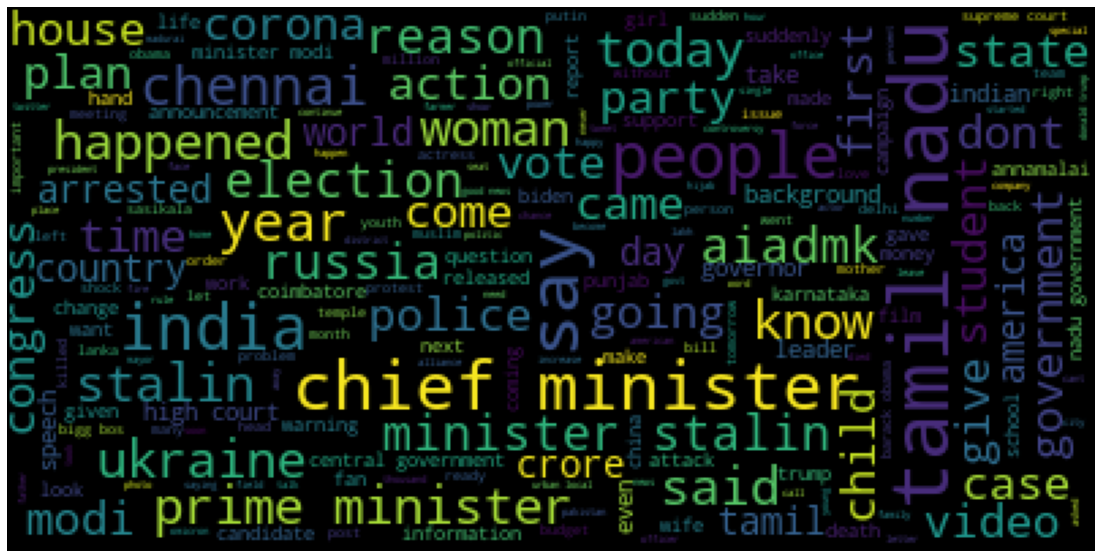

In [7]:
# Generate a basic word cloud 
from wordcloud import WordCloud, ImageColorGenerator

text = " ".join([x for x in data['clean_text']])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=30, max_words=1000).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [8]:
# # Convert label in to binary

# data['label'] = [1 if x == 'FAKE' else 0 for x in data['label']]
data.head()

,Unnamed: 0,English,Tamil,Is Fake,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,0,"""There is no precaution"".. Scolded Chief Minis...",சபரிமலையில் குவியும் பக்தர்கள்: ஐயப்பனை இரவு 1...,0,There is no precaution Scolded Chief Minister ...,"[there, is, no, precaution, scolded, chief, mi...","[there, precaution, scolded, chief, minister, ...","[precaution, scolded, chief, minister, stalin,...","[precaution, scolded, chief, minister, stalin,...",precaution scolded chief minister stalin diffi...
1,1,34 people have corona in Saidapet Govt Trainin...,ஆரியங்காவு தர்மசாஸ்தா அன்னை புஷ்கலா தேவி திரு...,0,34 people have corona in Saidapet Govt Trainin...,"[34, people, have, corona, in, saidapet, govt,...","[people, have, corona, saidapet, govt, trainin...","[people, corona, saidapet, govt, training, cen...","[people, corona, saidapet, govt, training, cen...",people corona saidapet govt training center he...
2,2,Hanuman Jayanti at Dhanwandri Peedam: 100008 V...,புலிவாகனத்தில் மகரசங்கராந்தி பிரவேசம் - யாருக்...,0,Hanuman Jayanti at Dhanwandri Peedam 100008 Va...,"[hanuman, jayanti, at, dhanwandri, peedam, 100...","[hanuman, jayanti, dhanwandri, peedam, 100008,...","[hanuman, jayanti, dhanwandri, peedam, 100008,...","[hanuman, jayanti, dhanwandri, peedam, 100008,...",hanuman jayanti dhanwandri peedam 100008 vada ...
3,3,Happy New Year 2022: Do you know which country...,தன்வந்திரி பீடத்தில் அனுமன் ஜெயந்தி: நாமக்கல் ...,0,Happy New Year 2022 Do you know which country ...,"[happy, new, year, 2022, do, you, know, which,...","[happy, year, 2022, know, which, country, welc...","[happy, year, 2022, know, country, welcomes, y...","[happy, year, 2022, know, country, welcome, ye...",happy year 2022 know country welcome year firs...
4,4,Devotees thronging Sabarimala: Allowed to visi...,"தடுப்பூசி போடலியா.. பேங்க், ஹோட்டல் கூட போக மு...",0,Devotees thronging Sabarimala Allowed to visit...,"[devotees, thronging, sabarimala, allowed, to,...","[devotees, thronging, sabarimala, allowed, vis...","[devotees, thronging, sabarimala, allowed, vis...","[devotee, thronging, sabarimala, allowed, visi...",devotee thronging sabarimala allowed visit ayy...


**SPLITTING THE DATASET**

In [9]:
X_train,X_test,y_train,y_test = train_test_split(data['clean_text'], data['English'], test_size=0.25, random_state = 5)

print(X_train.shape)
print(X_test.shape)

(10923,)
(3641,)


**TF-IDF VECTORIZER**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print(tfidf_train.toarray())
print(tfidf_train.shape)
print(tfidf_test.toarray())
print(tfidf_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10923, 13784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3641, 13784)


**PASSIVE AGGRESSIVE CLASSIFIER**

In [11]:
# Passive Aggresive Classifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

pred = pac.predict(tfidf_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))

Accuracy score : 0.06097226036803076
Confusion matrix : 
 [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**LOGISTIC REGRESSION**

In [ ]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 5)
lr.fit(tfidf_train, y_train)
print('Logistic Regression model fitted..')

pred = lr.predict(tfidf_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))

**XGBOOST CLASSIFIER**

In [ ]:
import xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(tfidf_train, y_train)

print('XGBoost Classifier model fitted..')
pred = xgb.predict(tfidf_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))

**LIGHTGBM CLASSIFIER**

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(tfidf_train, y_train)

print('LightGBM Classifier model fitted..')
pred = lgbm.predict(tfidf_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))

In [9]:
nltk.data.path

['C:\\Users\\HP/nltk_data',
 'C:\\Users\\HP\\anaconda3\\nltk_data',
 'C:\\Users\\HP\\anaconda3\\share\\nltk_data',
 'C:\\Users\\HP\\anaconda3\\lib\\nltk_data',
 'C:\\Users\\HP\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data']